# What's Cooking?

This is a competition from Kaggle.com where teams are asked to try to predict the cuisine given a list of ingredients. We have 39773 recipes in json files which we will try to analyse and find patterns. Later we will use these patterns to predict a cuisine type for a new recipe.

Importing Python modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline
import re
import nltk
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Liliya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading available recipes

In [2]:
train = pd.read_json('https://raw.githubusercontent.com/lpanfilova/ML_classification_problem_whats_cooking/main/train.json')

### Below are a few examples of recipes:

In [3]:
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


## Training and validation data

In [4]:
train_shuf = train.sample(frac=1)

In [5]:
# Because Kaggle's test set doesn't have true labels, let's use a portion of the train set for testing.
TRAINING_SIZE = 30000
all_cuisines = train_shuf['cuisine'].values.tolist()
all_train_recipes = train_shuf['ingredients'].values.tolist()
train_recipes = all_train_recipes[:TRAINING_SIZE]
test_recipes = all_train_recipes[TRAINING_SIZE:]
train_cuisines = all_cuisines[:TRAINING_SIZE]
test_cuisines = all_cuisines[TRAINING_SIZE:]

print(f'TRAIN: Num recipes = {len(train_recipes)}')
print(f'TRAIN: Num unique ingredients = {len(set([ingr for recipe in train_recipes for ingr in recipe]))}')
print(f'TEST: Num recipes = {len(test_recipes)}')
print(f'TEST: Num unique ingredients = {len(set([ingr for recipe in test_recipes for ingr in recipe]))}')

TRAIN: Num recipes = 30000
TRAIN: Num unique ingredients = 6234
TEST: Num recipes = 9774
TEST: Num unique ingredients = 4448


## Data Cleaning

Original train dataset showed high variability of the ingredient records. Same or similar ingredients could have been written in multiple ways. To reduce the dimensionality of the dataset and improve the modelling the following data
preprocessing steps were taken: removal of special characters, numbers and capital letters, removal of stop words, and stemming.

#### Removing irrelevant words from ingredients.

In [6]:
PS = PorterStemmer()

def normalize_word(word):
    norm_word = PS.stem(word)
    return norm_word

non_ing_words = ['food', 'center', 'oz', 'double', 'compressed', 'homemade', 'bottled', 'plus', 'in', 'and', 'ready', 'au', 
             'drained', 'paper', 'mince', 'added', 'piece', 'challenge', 'grated', 'less', 'bottle', 'cloud', 'bottoms', 
             'size', 'medium', 'peel', 'acting', 'based', 'full', 'grating', 'world', 'ml', 'freshly', 'vegan', 'finely', 
             'bottom', 'fat', 'fashioned', 'high', 'for', 'comfort', 'ao', 'dinosaur', 'bought', 'nonstick', 'crumbled', 
             'instant', 'dinner', 'fine', 'blade', 'cut', 'diced', 'promise', 'new', 'mix', 'pan', 'layer', 'miniature', 
             'mashed', 'field', 'straight', 'precooked', 'regular', 'warm', 'reduced', 'imitation', 'peeled', 'islands', 
             'fresh', 'dress', 'prepar', 'minced', 'home', 'ground', 'store', 'country', 'distilled', 'mini', 'nonfat', 
             'beaten', 'hand', 'it', 'stir', 'success', 'domino', 'granny', 'frozen', 'old', 'farm', 'minute', 'drink', 
             'mild', 'miracle', 'of', 'sliced', 'TACO BELL', 'half', 'pure', 'KRAFT', 'natural', 'believ', 'land', 'style', 
             'well', 'canned', 'no', 'collect', 'purpose', 'boil', 'side', 'prebaked', 'light', 'digestive', 'accompaniment', 
             'aka', 'farmer', 'grade', 'disco', 'quick', 'english', 'lower', 'hot', 'brand', 'part', 'kitchen', 'concentrate', 
             'four', 'free', 'extra', 'glutein', 'pieces', 'energy', 'culinary', 'chopped', 'fluff', 'rich', 'wok', 'inch', 
             'oven', 'large', 'pot', 'organic', 'forest', 'diamond', 'serving', 'calorie', 'mrs', 'club', 'crushed', 'farms', 
             'doubl', 'Heinz', 'grand', 'lowfat', 'short', 'broad', 'fatfree', 'me', 'hair', 'classic', 'firmly', 'giant', 
             'lite', 'drain', 'whole', 'small', 'any', 'cooking', 'flat', 'diet', 'believe', 'mary', 'bee', 'thousand', 
             'quarters', 'best', 'crusty', 'or', 'cooked', 'an', 'beaters', 'to', 'do', 'cold', 'virgin', 'simple', 'fully', 
             'g', 'imperial', 'cuts', 'dish', 'plain', 'unsalted', 'homestyl', 'one', 'all', 'real', 'lb', 'premium', 'con', 
             'pound', 'made', 'on', 'fast', 'prepared', 'campbell', 'lady', 'hothouse', 'california', 'pain', 'equal', 'low', 
             'filled', 'dried', 'shredded', 'parts', 'good', 'into', 'island', 'sodium', 'kg', 'covered', 'firm', 'hidden']

def preprocess_recipes(recipes):
    processed_recipes = []

    for recipe in recipes:
        processed_recipe = []
    
        for ingredient in recipe:
            words = re.sub('[^A-Za-z]', ' ', ingredient).split()
            words = [w.lower() for w in words if len(w) > 0]
            good_words = [w for w in words if not w in non_ing_words]
            norm_words = [normalize_word(w) for w in good_words]
            processed_ingredient = ' '.join(norm_words)
            processed_recipe.append(processed_ingredient)

        processed_recipes.append(processed_recipe)
        
    return processed_recipes

#### Removing special characters and numbers

In [7]:
ingredients_set = set()
for x in train['ingredients']:

    for y in x:
        ingredients_set.add(y) 

all_chars = ' '.join(ingredients_set)
spec_chars = sorted([char for char in set(all_chars) if re.findall('[^A-Za-z ]', char)])
num_recipes_with_spec_chars = len([r for r in all_train_recipes if any(c in ' '.join(r) for c in spec_chars)])
num_recipes_with_num = len([r for r in all_train_recipes if any(c in ' '.join(r) for c in '[0-9]')])
num_recepies_with_cap = len([r for r in all_train_recipes if any(c in ' '.join(r) for c in '[A-Z]')])

print(f'The removed special characters and numbers are: \n {spec_chars} \n')
print(f'Num recipes with special characters is: {num_recipes_with_spec_chars}')
print(f'Num recipes with numbers is: {num_recipes_with_num}')
print(f'Num recipes with capital letters is: {num_recepies_with_cap}')

The removed special characters and numbers are: 
 ['!', '%', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '®', 'â', 'ç', 'è', 'é', 'í', 'î', 'ú', '’', '€', '™'] 

Num recipes with special characters is: 11440
Num recipes with numbers is: 10080
Num recipes with capital letters is: 10277


In [8]:
processed_train_recipes = preprocess_recipes(train_recipes)
print(f'TRAIN Num processed recipes = {len(processed_train_recipes)}')
print(f'TRAIN Num unique processed ingredients = {len(set([ingr for recipe in processed_train_recipes for ingr in recipe]))}')

TRAIN Num processed recipes = 30000
TRAIN Num unique processed ingredients = 5074


In [9]:
processed_test_recipes = preprocess_recipes(test_recipes)
print(f'TEST Num processed recipes = {len(processed_test_recipes)}')
print(f'TEST Num unique processed ingredients = {len(set([ingr for recipe in processed_test_recipes for ingr in recipe]))}')

TEST Num processed recipes = 9774
TEST Num unique processed ingredients = 3616


# Exploratory Data Analysis

### The bar plot below shows the number of recipes for each cuisine:

Text(0.5, 1.0, 'Number of recipes per cuisine in training data')

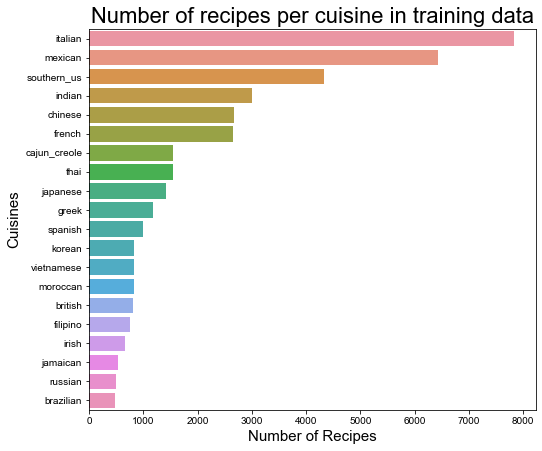

In [10]:
cuisine_freq = train['cuisine'].value_counts()
plt.figure(figsize=(8,7))
ax = sns.barplot(x = cuisine_freq, y = cuisine_freq.index)
sns.set(font_scale = 1.2)
plt.xlabel("Number of Recipes", size=15)
plt.ylabel("Cuisines", size=15)
plt.title("Number of recipes per cuisine in training data", size=22)

From the above visualization we can determine that the data is imbalanced, as some cuisines like Italian and Mexican are over-represented, while others Jamaican, Russian and Brazilian are minority classes.

In [12]:
training_data = pd.DataFrame({'cuisines':train_cuisines, 'recipes':processed_train_recipes})
training_data['num_ing'] = training_data['recipes'].str.len()

Text(0.5, 1.0, 'Avg number of ingredients per cuisine in training data')

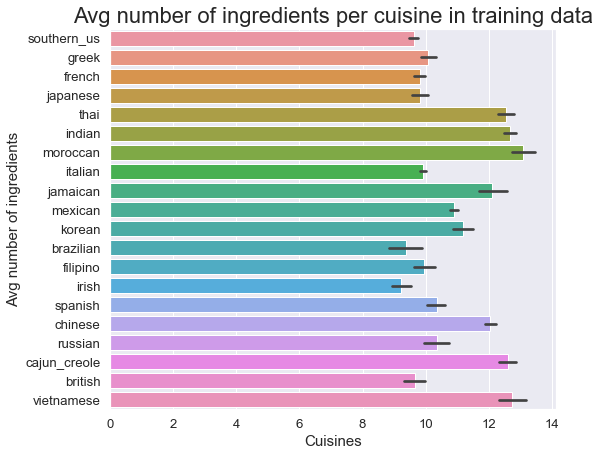

In [13]:
plt.figure(figsize=(8,7))
ax = sns.barplot(x = training_data['num_ing'], y = training_data['cuisines'])
sns.set(font_scale = 1.2)
plt.xlabel("Cuisines", size=15)
plt.ylabel("Avg number of ingredients", size=15)
plt.title("Avg number of ingredients per cuisine in training data", size=22)

In [14]:
ing_list = []
for recipe in processed_train_recipes:
    for ing in recipe:
        ing_list.append(ing)

ing_df = pd.DataFrame(ing_list)

ing_freq = ing_df.value_counts()
ing_freq = ing_freq.to_frame()
ing_freq.columns =['freq']
ing_freq = ing_freq.reset_index(drop=False)
ing_freq.columns =['ing','freq']
ing_freq_top = ing_freq.head(30)

Text(0.5, 1.0, 'Most frequently used ingredients')

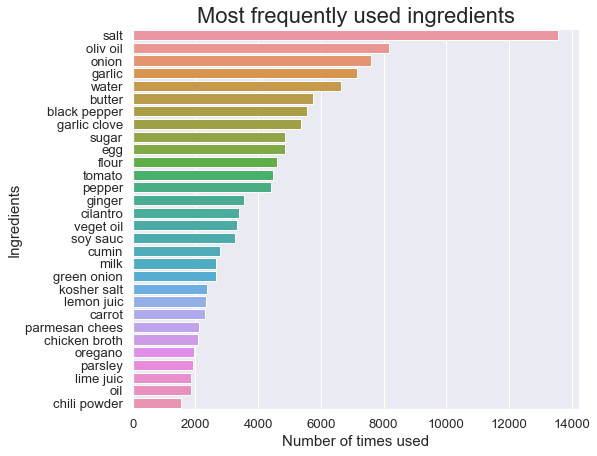

In [15]:
plt.figure(figsize=(8,7))
ax = sns.barplot(x = ing_freq_top['freq'], y = ing_freq_top['ing'])
sns.set(font_scale = 1.2)
plt.xlabel("Number of times used", size=15)
plt.ylabel("Ingredients", size=15)
plt.title("Most frequently used ingredients", size=22)

## Creating a logistic regression model to predict cuisine for a new recipe

We are going to apply a statistical model to check whether it is possible to predict the cuisine based on ingredient list. First, we split our data into training and validation parts. Training part is used by our model to find patterns and validation part - to test whether we predict accurately enough. After that, we clean our data from numbers, special characters and non-ingredient words etc. Once we applied our model we get the accuracy result of 0.78. This means that 78% of cuisines were preducted correctly.

### Logistic Regression

We have a multiclass classification problem of predicting one of 20 cuisines by the recipe. The logistic regression analysis is used for classification problems with binary dependent variables. Therefore, we converted the original problem of predicting cuisine for a recipe into a problem of predicting likelihood of the recipe belonging to each of the 20 cuisines in the dataset
with the highest likelihood cuisine being the final answer.



## Encoding 

Cuisines and recipes had to be encoded because all the algorithms which we can
potentially leverage can only consume numerical data. Cuisines were encoded in the simplest way, i.e. as integers.
Recipes were encoded using one-hot encoding where each recipe is represented by a vector of zeros and ones. Each zero or one stands for whether an ingredient was or was not used in the recipe.

#### Encoding cuisines

In [16]:
le = preprocessing.LabelEncoder()
le.fit(train_cuisines)
y_train = le.transform(train_cuisines)
y_test = le.transform(test_cuisines)

#### Encoding recipes

In [17]:
mlb = MultiLabelBinarizer()
mlb.fit(processed_train_recipes)
x_train = mlb.transform(processed_train_recipes)
x_test = mlb.transform(processed_test_recipes)

## Creating a logistic regression model

In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

## Accuracy

### The overall accuracy of our model is 77%, which appears to be a good result given that we have 20 cuisines.

In [19]:
#The best score is: 0.7915899324739104
model.score(x_test, y_test)

0.7731737262124002

### Confusion Matrix

The confusion matrix represents how cuisines were predicted by our model. On the vertical axis there are actual cuisines (labels), while on a horizontal axis there are predicted cuisines. So, for example for Brazilian cuisine, 72
recipes were predicted correctly, 12 were falsely predicted as Mexican, 5
as Indian, and 4 as Italian.

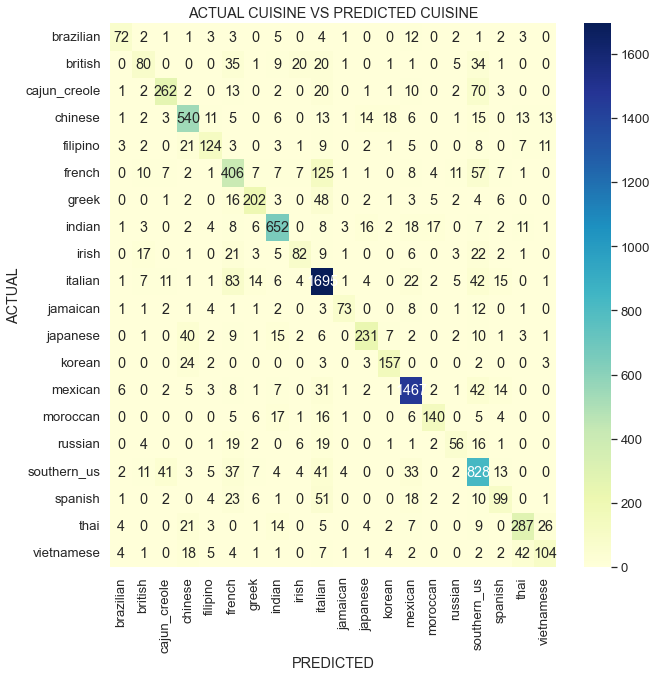

In [20]:
cm = confusion_matrix(y_test, model.predict(x_test))
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(cm, annot = True, fmt ='d',cmap="YlGnBu", xticklabels = le.classes_,
            yticklabels = le.classes_)
plt.ylabel('ACTUAL')
plt.xlabel('PREDICTED')
ax.set_title('ACTUAL CUISINE VS PREDICTED CUISINE')
plt.show()

### Classification report

This classification report shows the precision (percentage of true positives within all predicted positives), recall (percentage of correctly predicted true positives) and f1-score (a weighted average of precision and recall). The overall accuracy of our model is 79%, which appears to be a good result given that we have 20 cuisines. A random guessing would only have 5% accuracy. We can observe the highest precision and recall for Indian, Italian and Mexican cuisines, probably because of the large amount of training data and the ratio of unique ingredients defining it.

In [21]:
print(classification_report(y_test, model.predict(x_test), target_names = le.classes_))

              precision    recall  f1-score   support

   brazilian       0.74      0.64      0.69       112
     british       0.56      0.38      0.46       208
cajun_creole       0.79      0.67      0.73       389
     chinese       0.79      0.82      0.80       662
    filipino       0.72      0.62      0.66       200
      french       0.58      0.61      0.60       662
       greek       0.78      0.68      0.73       295
      indian       0.86      0.86      0.86       761
       irish       0.65      0.47      0.55       173
     italian       0.79      0.89      0.84      1915
    jamaican       0.82      0.66      0.73       111
    japanese       0.82      0.69      0.75       333
      korean       0.80      0.81      0.81       194
     mexican       0.90      0.92      0.91      1593
    moroccan       0.80      0.70      0.75       201
     russian       0.59      0.44      0.50       128
 southern_us       0.69      0.80      0.74      1035
     spanish       0.58    

In [22]:
processed_recipes = processed_train_recipes.copy()
processed_recipes.extend(processed_test_recipes)

unique_cuisines = set(all_cuisines)
ingredients_for_cuisines = {}

for cuisine in unique_cuisines:
    ingredients_for_cuisines[cuisine] = set([ingr for i,r in enumerate(processed_recipes) 
                                             for ingr in r if all_cuisines[i] == cuisine])
    
for cuisine in unique_cuisines:
    unique_ingrs = [ingr for ingr in ingredients_for_cuisines[cuisine] 
                    if not any(other_cuisine
                               for other_cuisine in unique_cuisines
                               if other_cuisine != cuisine and 
                               ingr in ingredients_for_cuisines[other_cuisine])]
    print(f'{cuisine}: {len(unique_ingrs)} unique ingreduents which is {round(len(unique_ingrs)/len(ingredients_for_cuisines[cuisine])*100,1)}% of all ingredients in this cuisine.')

italian: 369 unique ingreduents which is 15.9% of all ingredients in this cuisine.
brazilian: 41 unique ingreduents which is 5.9% of all ingredients in this cuisine.
greek: 56 unique ingreduents which is 5.9% of all ingredients in this cuisine.
french: 165 unique ingreduents which is 9.6% of all ingredients in this cuisine.
cajun_creole: 85 unique ingreduents which is 6.8% of all ingredients in this cuisine.
chinese: 166 unique ingreduents which is 11.3% of all ingredients in this cuisine.
vietnamese: 41 unique ingreduents which is 4.4% of all ingredients in this cuisine.
spanish: 49 unique ingreduents which is 4.7% of all ingredients in this cuisine.
russian: 43 unique ingreduents which is 6.2% of all ingredients in this cuisine.
mexican: 354 unique ingreduents which is 16.7% of all ingredients in this cuisine.
japanese: 128 unique ingreduents which is 10.6% of all ingredients in this cuisine.
thai: 66 unique ingreduents which is 5.9% of all ingredients in this cuisine.
filipino: 44 u

### Conclusion

   In conclusion we were successfully able to create a model with approximately 79% accuracy of determining a type of cuisine based on ingredients. There are several ingredients such as Kimchi, turmeric and snails that are unique to a specific cuisine, which aids the model. Based on the values of precision and accuracy that the model appears to be good enough.
   However, as identified previously there are many cuisines with similar ingredients in result there was significant false prediction. Therefore, with more data it is possible to reduce error and create clusters of a combination of ingredients and quantities, specific to types of cuisines.
   This model is a suitable steppingstone in predicting types of cuisines of a recipe using ingredients, with enough accuracy. With additional recipes the model will only improve and yield the intended results.